In [ ]:
import os
import tempfile
import time
import numpy as np
import faiss
import h5py
import requests
from collections import defaultdict
import bisect


# Constants
DATA_URL = "http://ann-benchmarks.com/fashion-mnist-784-euclidean.hdf5"
CACHE = os.path.join(tempfile.gettempdir(), "fashion-mnist-784-euclidean.hdf5")
k = 10

In [2]:
print("Step 1: Download Fashion-MNIST dataset if not cached")
if not os.path.exists(CACHE):
    print("Downloading Fashion-MNIST (~300 MB)…")
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(DATA_URL, headers=headers)
    if response.status_code == 200:
        with open(CACHE, "wb") as f:
            f.write(response.content)
    else:
        raise Exception(f"Failed to download dataset: HTTP{response.status_code}")

Step 1: Download Fashion-MNIST dataset if not cached


In [3]:
print("Step 2: Load data from HDF5 file")
with h5py.File(CACHE, "r") as f:
    xb = f["train"][:].astype(np.float32)
    xq = f["test"][:].astype(np.float32)
    gt = f["neighbors"][:]

d = xb.shape[1]

Step 2: Load data from HDF5 file


In [4]:
print("Step 3: KMeans with 100 clusters (inner level, Euclidean)")
train_sample = xb[np.random.choice(len(xb), size=min(50000, len(xb)), replace=False)]
inner_kmeans = faiss.Kmeans(d, 100, niter=20, verbose=True, spherical=False)
inner_kmeans.train(train_sample)
_, xb_inner_assignments = inner_kmeans.index.search(xb, 1)
_, xq_inner_assignments = inner_kmeans.index.search(xq, 10)

Step 3: KMeans with 100 clusters (inner level, Euclidean)
Sampling a subset of 25600 / 50000 for training
Clustering 25600 points in 784D to 100 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.04 s
  Iteration 19 (0.62 s, search 0.54 s): objective=3.38691e+10 imbalance=1.188 nsplit=0       


In [5]:
print("Step 4: KMeans with 10 clusters (outer level, Euclidean)")
inner_centroids = inner_kmeans.centroids
outer_kmeans = faiss.Kmeans(d, 10, niter=20, verbose=True, spherical=False)
outer_kmeans.train(inner_centroids)
_, inner_to_outer = outer_kmeans.index.search(inner_centroids, 1)
_, xq_outer_assignments = outer_kmeans.index.search(xq, 3)

Step 4: KMeans with 10 clusters (outer level, Euclidean)
Clustering 100 points in 784D to 10 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.01 s, search 0.00 s): objective=1.03083e+08 imbalance=1.210 nsplit=0       


WARNING clustering 100 points to 10 centroids: please provide at least 390 training points


In [6]:
print("Step 5: Pre-group vectors and store dist + cos to centroid (sorted)")
outer_to_inner_to_points = defaultdict(lambda: defaultdict(list))
vector_metadata = defaultdict(dict)
for idx, inner_id in enumerate(xb_inner_assignments[:, 0]):
    outer_id = inner_to_outer[inner_id][0]
    centroid = inner_centroids[inner_id]
    vec = xb[idx]
    dist = np.linalg.norm(vec - centroid)
    cos_sim = np.dot(vec, centroid) / (np.linalg.norm(vec) * np.linalg.norm(centroid) + 1e-8)
    vector_metadata[outer_id].setdefault(inner_id, []).append((dist, cos_sim, idx))

# Sort each list by Euclidean distance to centroid
for outer_id in vector_metadata:
    for inner_id in vector_metadata[outer_id]:
        vector_metadata[outer_id][inner_id].sort()
        outer_to_inner_to_points[outer_id][inner_id] = [t[2] for t in vector_metadata[outer_id][inner_id]]

# After Step 5: Pre-group vectors and store dist + cos to centroid (sorted)
# Record the number of inner clusters for each outer cluster
outer_to_num_inner_clusters = {}
for outer_id in vector_metadata:
    outer_to_num_inner_clusters[outer_id] = len(vector_metadata[outer_id])

print("\nNumber of inner clusters for each outer cluster:")
for outer_id in sorted(outer_to_num_inner_clusters):
    print(f"Outer cluster {outer_id}: {outer_to_num_inner_clusters[outer_id]} inner clusters")

Step 5: Pre-group vectors and store dist + cos to centroid (sorted)

Number of inner clusters for each outer cluster:
Outer cluster 0: 13 inner clusters
Outer cluster 1: 7 inner clusters
Outer cluster 2: 19 inner clusters
Outer cluster 3: 8 inner clusters
Outer cluster 4: 14 inner clusters
Outer cluster 5: 15 inner clusters
Outer cluster 6: 5 inner clusters
Outer cluster 7: 6 inner clusters
Outer cluster 8: 7 inner clusters
Outer cluster 9: 6 inner clusters


Step 6: Evaluate n_probe_inner from 1 to 15

Evaluating n_probe_inner = 1
n_probe_inner=1: recall=0.4014, qps=226.89

Evaluating n_probe_inner = 2
n_probe_inner=2: recall=0.6064, qps=117.35

Evaluating n_probe_inner = 3
n_probe_inner=3: recall=0.6866, qps=80.16

Evaluating n_probe_inner = 4
n_probe_inner=4: recall=0.7136, qps=61.89

Evaluating n_probe_inner = 5
n_probe_inner=5: recall=0.7234, qps=50.58

Evaluating n_probe_inner = 6
n_probe_inner=6: recall=0.7296, qps=43.77

Evaluating n_probe_inner = 7
n_probe_inner=7: recall=0.7678, qps=38.54

Evaluating n_probe_inner = 8
n_probe_inner=8: recall=0.8021, qps=34.06

Evaluating n_probe_inner = 9
n_probe_inner=9: recall=0.8175, qps=4.40

Evaluating n_probe_inner = 10
n_probe_inner=10: recall=0.8201, qps=4.28

Evaluating n_probe_inner = 11
n_probe_inner=11: recall=0.8205, qps=3.68

Evaluating n_probe_inner = 12
n_probe_inner=12: recall=0.8218, qps=8.33

Evaluating n_probe_inner = 13
n_probe_inner=13: recall=0.8221, qps=24.23

Evaluating n_

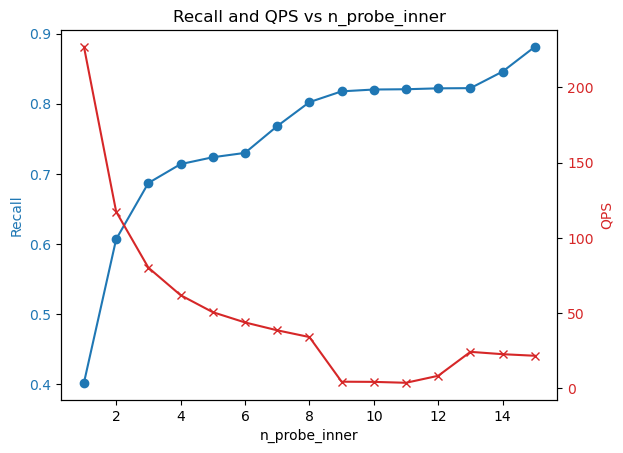

In [11]:
import matplotlib.pyplot as plt
print("Step 6: Evaluate n_probe_inner from 1 to 15")
recalls = []
qps_list = []
probe_range = range(1, 16)

for n_probe_inner in probe_range:
    print(f"\nEvaluating n_probe_inner = {n_probe_inner}")
    I = []
    D = []
    skip_counter = 0
    start_time = time.time()
    for i, x in enumerate(xq):
        outer_ids = xq_outer_assignments[i]
        best_heap = []
        tau = float("inf")
        inner_probed = 0

        for outer_id in outer_ids:
            if outer_id not in outer_to_inner_to_points:
                continue

            inner_ids = list(outer_to_inner_to_points[outer_id].keys())
            num_to_probe = min(n_probe_inner - inner_probed, len(inner_ids))
            if num_to_probe <= 0:
                break

            inner_centroids_subset = inner_kmeans.centroids[inner_ids]
            index_l2 = faiss.IndexFlatL2(d)
            index_l2.add(inner_centroids_subset)
            _, inner_ranks_local = index_l2.search(x.reshape(1, -1), num_to_probe)
            selected_inner_ids = [inner_ids[j] for j in inner_ranks_local[0] if j < len(inner_ids)]

            for inner_id in selected_inner_ids:
                idxs_meta = vector_metadata[outer_id][inner_id]
                if not idxs_meta:
                    continue
                centroid = inner_centroids[inner_id]
                d_qc = np.linalg.norm(x - centroid)
                distances = [meta[0] for meta in idxs_meta]
                start = bisect.bisect_left(distances, d_qc)

                left = start - 1
                right = start
                while left >= 0 or right < len(idxs_meta):
                    for direction in (left, right):
                        if direction < 0 or direction >= len(idxs_meta):
                            continue
                        dist_ic, cos_theta, idx = idxs_meta[direction]
                        lower_bound = abs(d_qc - dist_ic)
                        upper_bound = d_qc + dist_ic
                        if lower_bound > tau:
                            skip_counter += 1
                            continue
                        est_dist = np.sqrt(max(0.0, d_qc ** 2 + dist_ic ** 2 - 2 * d_qc * dist_ic * cos_theta))
                        if est_dist > tau:
                            skip_counter += 1
                            continue
                        actual_dist = np.linalg.norm(x - xb[idx])
                        best_heap.append((actual_dist, idx))
                        if len(best_heap) > k:
                            best_heap.sort()
                            best_heap = best_heap[:k]
                            tau = best_heap[-1][0]
                    left -= 1
                    right += 1

            inner_probed += num_to_probe
            if inner_probed >= n_probe_inner:
                break

        if best_heap:
            best_heap.sort()
            I.append([idx for _, idx in best_heap])
            D.append([dist for dist, _ in best_heap])
        else:
            dists = np.linalg.norm(xb - x.reshape(1, -1), axis=1)
            idx = np.argsort(dists)[:k]
            I.append(idx)
            D.append(dists[idx])

    D = np.array(D)
    I = np.array(I)
    elapsed_time = time.time() - start_time
    qps = len(xq) / elapsed_time
    recall = (I == gt[:, :k]).sum() / (gt.shape[0] * k)
    recalls.append(recall)
    qps_list.append(qps)
    print(f"n_probe_inner={n_probe_inner}: recall={recall:.4f}, qps={qps:.2f}")

# Plot recall and QPS vs n_probe_inner
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('n_probe_inner')
ax1.set_ylabel('Recall', color=color)
ax1.plot(probe_range, recalls, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('QPS', color=color)
ax2.plot(probe_range, qps_list, marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Recall and QPS vs n_probe_inner')
plt.show()

In [ ]:
print("Step 6: Search using 2-level KMeans with lower and upper bounds")
start_time = time.time()
I = []
D = []
skip_counter = 0
for i, x in enumerate(xq):
    outer_ids = xq_outer_assignments[i]
    best_heap = []  # (distance, idx)
    tau = float("inf")

    for outer_id in outer_ids:
        if outer_id not in outer_to_inner_to_points:
            continue

        inner_ids = list(outer_to_inner_to_points[outer_id].keys())
        inner_centroids_subset = inner_kmeans.centroids[inner_ids]
        index_l2 = faiss.IndexFlatL2(d)
        index_l2.add(inner_centroids_subset)
        _, inner_ranks_local = index_l2.search(x.reshape(1, -1), 10)
        selected_inner_ids = [inner_ids[j] for j in inner_ranks_local[0] if j < len(inner_ids)]

        for inner_id in selected_inner_ids:
            idxs_meta = vector_metadata[outer_id][inner_id]
            if not idxs_meta:
                continue
            centroid = inner_centroids[inner_id]
            d_qc = np.linalg.norm(x - centroid)
            distances = [meta[0] for meta in idxs_meta]
            start = bisect.bisect_left(distances, d_qc)

            left = start - 1
            right = start
            while left >= 0 or right < len(idxs_meta):
                for direction in (left, right):
                    if direction < 0 or direction >= len(idxs_meta):
                        continue
                    dist_ic, cos_theta, idx = idxs_meta[direction]
                    lower_bound = abs(d_qc - dist_ic)
                    upper_bound = d_qc + dist_ic
                    if lower_bound > tau:
                        skip_counter += 1
                        continue
                    est_dist = np.sqrt(max(0.0, d_qc ** 2 + dist_ic ** 2 - 2 * d_qc * dist_ic * cos_theta))
                    if est_dist > tau:
                        skip_counter += 1
                        continue
                    actual_dist = np.linalg.norm(x - xb[idx])
                    best_heap.append((actual_dist, idx))
                    if len(best_heap) > k:
                        best_heap.sort()
                        best_heap = best_heap[:k]
                        tau = best_heap[-1][0]
                left -= 1
                right += 1

    if best_heap:
        best_heap.sort()
        I.append([idx for _, idx in best_heap])
        D.append([dist for dist, _ in best_heap])
    else:
        dists = np.linalg.norm(xb - x.reshape(1, -1), axis=1)
        idx = np.argsort(dists)[:k]
        I.append(idx)
        D.append(dists[idx])

D = np.array(D)
I = np.array(I)
elapsed_time = time.time() - start_time
qps = len(xq) / elapsed_time

In [8]:
print("Step 7: Compute recall")
recall = (I == gt[:, :k]).sum() / (gt.shape[0] * k)

print("Step 8: Output results")
print("Nearest neighbor indices (first 10 queries):")
print(I[:10])
print("\nDistances to nearest neighbors (first 10 queries):")
print(D[:10])
print(f"\nRecall@{k}:{recall:.4f}")
print(f"Queries per second:{qps:.2f} QPS")
print(f"Total vectors skipped due to early stopping: {skip_counter}")

Step 7: Compute recall
Step 8: Output results
Nearest neighbor indices (first 10 queries):
[[18094 53939 52468 15081 29768 21342 17346 45266   111 35541]
 [ 8572 31348  3884  9533 36846 24556 28082 55959 47667 30373]
 [  285 38143  3421 39889  9708 34763 59938 31406 48306 50936]
 [ 8903 53024 10359 43266 45767 36567 43719 16526  3475 40031]
 [42157 52774 45500 48271 50781 22532 19342 20434 36906 13987]
 [48183 19657 24300 11634  9319 40667 36856  7893  3243 47089]
 [40928  9900 56836  9614 58759 15553 36461 44552  8031 50062]
 [37417 16030 25159  1236 37330 54611 30730 28657 12173 30583]
 [36909 42558  2030 43083 13609 37675 34706 41586 47631 10677]
 [19782 10342 29714 20828 30704 14724 35814 22541 39971 14565]]

Distances to nearest neighbors (first 10 queries):
[[ 482.2966   681.9905   729.6321   762.0374   769.30096  791.26794
   823.932    829.3684   836.1902   858.7229 ]
 [1308.002   1329.3134  1382.7317  1387.0912  1393.9028  1400.1586
  1405.0463  1411.8608  1416.281   1417.4392